# Excercise 2

## Load the data

In [1]:
def load_data(pickle_file):
    import pickle

    with open(pickle_file, 'rb') as f:
        return pickle.load(f)

data = load_data('partial_notMNIST.pickle')
train_dataset = data['train_dataset']
train_labels = data['train_labels']
test_dataset = data['test_dataset']
test_labels = data['test_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']

## Plot the images

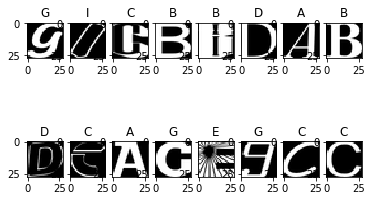

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

def label_to_char(one_hot):
    return "ABCDEFGHIJ"[one_hot]

n = 16
rows = 2
for i in range(1,1+n):
    image_to_show = random.randint(0,len(train_dataset))
    plt.subplot(rows,n/rows,i)
    plt.imshow(train_dataset[image_to_show], cmap="gray")
    plt.title(label_to_char(train_labels[image_to_show]))


## Helper Functions

In [3]:
image_size = 28
num_labels = 10

# Convert 2 to [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
def to_one_hot(labels):
    return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

def from_one_hot(labels):
    return np.argmax(labels,1)

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  labels = to_one_hot(labels)
  return dataset, labels

def print_row(cols, max_length=20):
    col_width = max_length
    print("".join(str(word).ljust(col_width) for word in cols))

## Simple classification pipeline

In [4]:
import numpy as np

def accuracy(predictions, labels):
    return (np.sum(np.array(predictions) == np.array(labels))
          / len(predictions))

def evaluate_classifier(classifier):  
    # Train
    classifier.fit(train_dataset, train_labels)
    
    # Evaluate
    predictions = classifier.predict(test_dataset)

    print("Test accuracy: %s" % accuracy(predictions, test_labels))
  



## Our first classifier

Our first classifier tries to guess the class of the input by selecting a class randomly. His accuracy is called the random baseline. If you train your real model, you need to have a better accuracy.

In [5]:
class RandomClassifier:
    import random
    
    def fit(self, train_dataset, train_labels):
        pass
    
    def predict(self, data):
        return [random.randint(0,9) for i in data]

In [6]:
evaluate_classifier(RandomClassifier())

Test accuracy: 0.102


## Hands-On: Logistic Regression

Now it's time to create your first real classifier. We are going to train the linear model you saw previously. To train the model you could use the same optimizer as in the first excercise. 

The linear model looks like this:

$$Wx + b = y$$

where
$W$ is a matrix of weights,
$x$ is the input vector
and $b$ is a vector of biases. The result $y$ are the logits.

As target for the optimizer you can use the predefined function `tf.nn.softmax_cross_entropy_with_logits` combinded with `tf.reduce_mean`.

**Hints**:

You can use the following functions:

    tf.matmul
    tf.nn.softmax
    tf.nn.softmax_cross_entropy_with_logits
    tf.reduce_mean


In [7]:
import tensorflow as tf

class TensorLogisticRegression:
    def __init__(self):
        self.num_training_steps = 1000
       
    def fit(self, train_dataset, train_labels):
        train_dataset, train_labels = reformat(train_dataset, train_labels)

        # Hands-On: Build Linear Model

        with tf.Session() as session:
            tf.global_variables_initializer().run()
            for step in range(self.num_training_steps):
               # train linear model
                pass

            # store trained model as instance variable

    def predict(self, testdata):
        testdata,_ = reformat(testdata, np.arange(10))
        
        # re-build model from instance variables
            
        with tf.Session() as session:
            tf.global_variables_initializer().run()
            
            # run model on test data
            return [0 for i in testdata]


In [8]:
evaluate_classifier(TensorLogisticRegression())

Test accuracy: 0.107
